In [2]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

# 构建LSTM模型以及调参

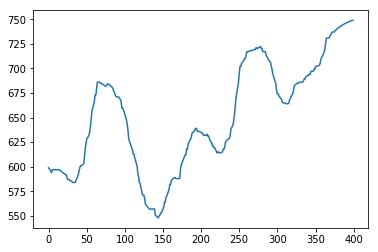

In [9]:
# 导入数据
dataframe = read_csv('data/train_data.csv', usecols=[1])
dataset = dataframe.values
# 转换数据类型float32
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

In [10]:
# X是T时间的价格，Y是T+N时间的价格
# 错位生成矩阵，生生对应特征向量
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
#         print(a)
        dataX.append(a)          
        b = dataset[i + look_back, 0]
#         print(b)
        dataY.append(b)
#         print("=======================")
    return numpy.array(dataX), numpy.array(dataY)
# 设置随机种子
numpy.random.seed(7)

In [11]:
# 整理规范数据
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)#缩小数据到指定范围内

# 切分训练数据和测试数据
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
# 为测试集和训练集建立模型函数,最终得到结果均为某1次数据对应X对应下一次数据Y
look_back = 7 
trainX,trainY = create_dataset(train, look_back)
testX,testY = create_dataset(test, look_back)

In [13]:
# reshape input to be [samples, time steps, features]
#重塑数据 输入集和的（数据，周期，特征）
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
from keras import regularizers

In [15]:
#使用LSTM神经网络
model = Sequential()
model.add(LSTM(6,activation='linear',recurrent_activation='linear',activity_regularizer=regularizers.l1(0.1),input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam',metrics=['mean_squared_error'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
312/312 [==============================] - 6s 21ms/step - loss: 0.0897 - mean_squared_error: 0.0571
Epoch 2/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0384 - mean_squared_error: 0.0106
Epoch 3/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0283 - mean_squared_error: 0.0091
Epoch 4/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0230 - mean_squared_error: 0.0087
Epoch 5/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0212 - mean_squared_error: 0.0086
Epoch 6/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0200 - mean_squared_error: 0.0080
Epoch 7/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0194 - mean_squared_error: 0.0080
Epoch 8/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0186 - mean_squared_error: 0.0076
Epoch 9/10
312/312 [==============================] - 2s 7ms/step - loss: 0.0179 - mean_squared_error: 0.0071
Epoch 10/

In [16]:
#做出预测(结果为标准化数据)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [17]:
#反预测，反标准化
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [18]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15.62 RMSE
Test Score: 21.53 RMSE


In [1]:
# 训练数据图
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# 测试数据图
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


# 原始数据图
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'numpy' is not defined

# 保存模型

In [13]:
from keras.models import load_model
model.save('model/LSTM回归业务.h5') 

# 载入模型并预测

In [14]:
from keras.models import load_model
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline
model = load_model('model/LSTM回归业务.h5')

In [15]:
# 导入数据
dataframe = read_csv('data/test_data.csv')
dataset = dataframe.values
# 转换数据类型float32
dataset = dataset.astype('float32')

In [16]:
# 整理规范数据
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)#缩小数据到指定范围内

In [17]:
look_back=7

In [18]:
for i in range(len(dataset)-look_back):
    def forecast(model, batch_size, row):
        X = row[0:-1]
        X = X.reshape(1, 1, len(X))
        yhat = model.predict(X, batch_size=batch_size)
        return yhat[0,0]
    i_=i+look_back+1
#     print((i),(i_))
    dataset_new=dataset[i:i_]
#     print(dataset_new)
    forecast=forecast(model,1,dataset_new).reshape(1, -1)
    price = scaler.inverse_transform(forecast)
    print(price[0][0])

965.80676
960.7332
937.80963
947.02203
939.05365
929.8557
